In [123]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/brain-tumor/MRI images" /content/MRI_images

#1. Importing Libraries

In [157]:
import os
import numpy as np
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Load Dataset


In [158]:
train_dir="/content/drive/MyDrive/Colab Notebooks/brain-tumor/MRI images/Training"

test_dir="/content/drive/MyDrive/Colab Notebooks/brain-tumor/MRI images/Testing"

train_path = []
train_labels = []

test_path = []
test_labels = []

In [159]:
# Load and shuffle train data
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir,label)):
    train_path.append(os.path.join(train_dir,label,image))
    train_labels.append(label)

train_path,train_labels=shuffle(train_path,train_labels)

In [160]:
print(len(train_path))

5524


In [161]:
# Load and shuffle test data

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_path.append(os.path.join(test_dir,label,image))
    test_labels.append(label)


test_path,test_labels=shuffle(test_path,test_labels)



In [162]:
print(len(test_path))


1311


In [200]:
classnames = os.listdir(train_dir)
classnames


['pituitary', 'notumor', 'glioma', 'meningioma']

#3. Data Visualization

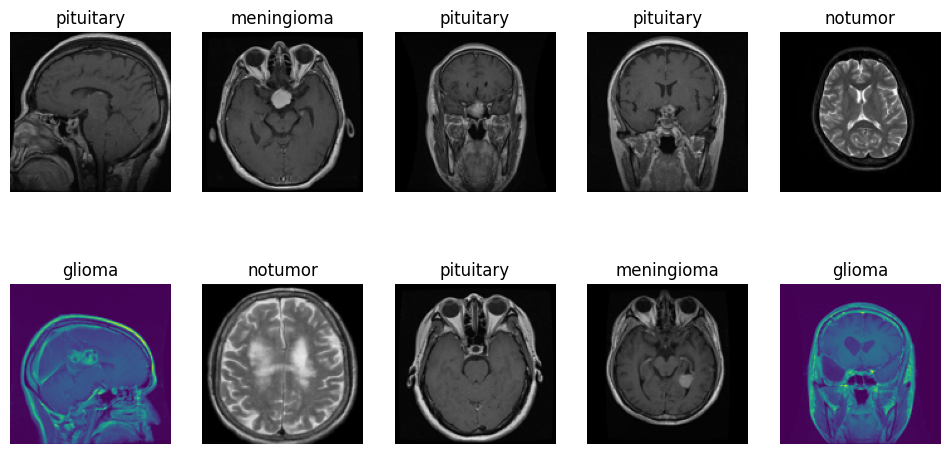

In [164]:
import random
import matplotlib.pyplot as plt


# Showing 10 Images

random_images = random.sample(range(len(train_path)),10)

fig, axes = plt.subplots(2,5,figsize=(12,6))
axes=axes.ravel()

for i,idx in enumerate(random_images):
  img_path = train_path[idx]
  img = Image.open(img_path)
  img=img.resize((128,128))

  axes[i].imshow(img)
  axes[i].axis("off")
  axes[i].set_title(f"{train_labels[idx]}")

plt.show()


#4. Image Preprocessing

In [165]:
# Image Augmentation Function

def augment_image(image):

  #changing to numpy array and then changing again to PIL
  image = Image.fromarray(np.uint8(image))

  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image = np.array(image)/255.0
  return image

In [166]:
# Load image and apply Augmentation

def open_images(paths):
  images=[]
  for path in paths:
    image=load_img(path,target_size=(128,128))
    image=augment_image(image)
    images.append(image)
  return np.array(images)

In [167]:
# Function for Encoding Labels

def encode_label(labels):
    encoded = [classnames.index(label) for label in labels]
    return np.array(encoded)


In [168]:
def datagen(paths,labels,batch_size=12,epochs=1):
  for _ in range(epochs):
    for i in range(0,len(paths),batch_size):

      batch_paths = paths[i:i + batch_size]
      batch_images = open_images(batch_paths)  #open and augment images

      batch_labels = labels[i:i + batch_size]
      batch_labels = encode_label(batch_labels) # encode labels

      yield batch_images,batch_labels





#5. Model Building

In [169]:
# Model architecture
base_model= VGG16(input_shape=(128,128,3),include_top=False,weights="imagenet")

# Freeze all layers of the vgg16 base model
for layer in base_model.layers:
  layer.trainable=False

# set only the last few layers
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

# Build model

model=Sequential()
model.add(Input(shape=(128,128,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(4,activation="softmax"))

# compile the model

model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

model.summary()




Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [170]:
# Parameters

batch_size=20
steps=int(len(train_labels)/batch_size)
epochs=10


# Train model

history=model.fit(
    datagen(train_path, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,steps_per_epoch=steps
)


Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - loss: 1.2158 - sparse_categorical_accuracy: 0.4479
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - loss: 0.5017 - sparse_categorical_accuracy: 0.8061
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.3086 - sparse_categorical_accuracy: 0.8887
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.2626 - sparse_categorical_accuracy: 0.9036
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.2066 - sparse_categorical_accuracy: 0.9294
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9297
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.1693 - sparse_categorical_accuracy: 0.9371
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.1213 - sparse_categorical_accuracy: 0.9534
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.1187 - sparse_categorical_accuracy: 0.9644
Epoch 10/10
276/276 ━━━━━━━━

#6. Plotting

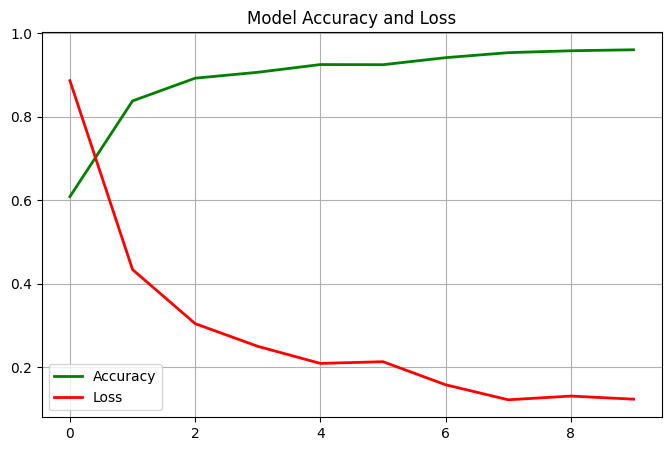

In [171]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.plot(history.history["sparse_categorical_accuracy"],"-g",linewidth=2)
plt.plot(history.history["loss"],"-r",linewidth=2)
plt.title("Model Accuracy and Loss")
plt.legend(["Accuracy","Loss"])
plt.show()


#7. Classification Report and Confusion matrix

In [172]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns


In [173]:
test_images=open_images(test_path)
test_labels_encoded=encode_label(test_labels)

test_prediction=model.predict(test_images)

print("classification report :")
print(classification_report(test_labels_encoded,np.argmax(test_prediction, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step
classification report :
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       300
           1       0.99      0.98      0.98       405
           2       0.97      0.76      0.85       300
           3       0.77      0.97      0.86       306

    accuracy                           0.92      1311
   macro avg       0.93      0.91      0.91      1311
weighted avg       0.93      0.92      0.92      1311



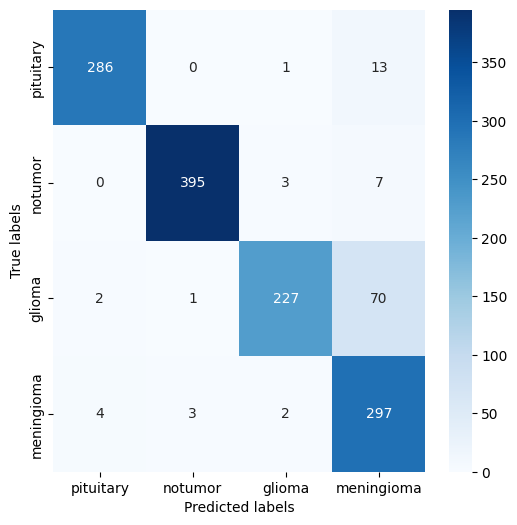

In [174]:
conf_mat=confusion_matrix(test_labels_encoded,np.argmax(test_prediction,axis=1))
plt.figure(figsize=(6,6))
sns.heatmap(conf_mat,annot=True,fmt="d",cmap="Blues",xticklabels=classnames,yticklabels=classnames)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

plt.show()

#8. Save the Model

In [189]:
save_path = "/content/drive/MyDrive/Colab Notebooks/brain-tumor/BTumor.h5"

In [190]:
model.save(save_path)

In [191]:
!pip freeze > requirements_full.txt


In [192]:
!cp /content/requirements_full.txt "/content/drive/MyDrive/Colab Notebooks/brain-tumor/requirements_full.txt"


#9. Predicting New Images

In [175]:
from PIL import Image
from tensorflow.keras.preprocessing import image

In [176]:
def predict_new_image(image_path):
  original_image=Image.open(image_path)

  img=image.load_img(image_path,target_size=(128,128))
  image_array=image.img_to_array(img)/255.0
  image_array=np.expand_dims(image_array,axis=0)

  prediction=model.predict(image_array)
  predicted_index=np.argmax(prediction)
  predicted_class=classnames[predicted_index]

  confidence = round(float(prediction[0][predicted_index]) * 100, 2)

  plt.imshow(original_image)
  plt.axis("off")
  plt.title(f"Predicted Tumor : {predicted_class} : {confidence}")
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


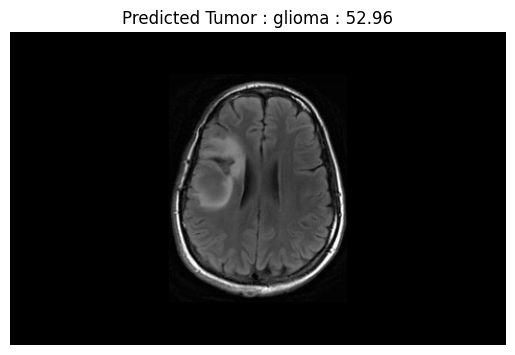

In [177]:
predict_new_image("/content/drive/MyDrive/Colab Notebooks/brain-tumor/glioma2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


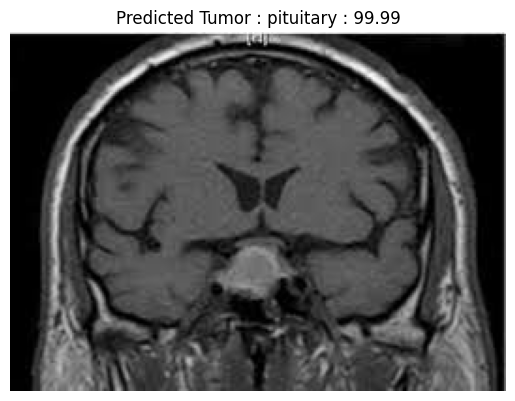

In [188]:
predict_new_image("/content/drive/MyDrive/Colab Notebooks/brain-tumor/pituitary3.jpg")